In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 3.2: MLP Regression: Settings

N_input = 100
N_hid = 10 # hidden nodes
N_output = 1 # output nodes
n_mlp = 50
x_values = np.linspace(-2, 2, N_input) # shape: (100,)
mlp_outputs = []
mlp_outputs_smooth = []

# define tanh function
def tanh(x):
    return np.tanh(x)

# derivative of tanh
def tanh_prime(x):
    return 1 - np.tanh(x)**2

# input x ~ U([0, 1]), target value y_T = sin(2*pi*x) + Gaussian noise with sd = 0.25
data = pd.read_csv("RegressionData.txt", header=None, delim_whitespace=True, names=["x", "y_T"])
x_data = np.array(data.x)[:, np.newaxis] # shape: (10, 1)
y_data = np.array(data.y_T)[:, np.newaxis] # shape: (10, 1)

# n_samples = 100
# x_data = np.sort(np.random.uniform(0, 1, n_samples))[:, np.newaxis]
# noise_std = 0.25
# noise = np.random.normal(0, noise_std, x_data.shape)
# y_data = np.sin(2*np.pi*x_data) + noise

N_h = 3
l_rate = 0.5
max_iter = 3000
tol = 1e-5

def train_mlp(x_datas, y_datas, N_h, l_rate, max_iter, tol):

    w10_reg = np.random.uniform(-0.5, 0.5, (1, N_h)) # shape: (1, 3)
    w21_reg = np.random.uniform(-0.5, 0.5, (N_h, 1)) # shape: (3, 1)
    b10 = np.random.uniform(-0.5, 0.5, (1, N_h)) # shape: (1, 3)
    b21 = np.random.uniform(-0.5, 0.5) # scalar: 1 output node

    iter = 0
    old_error = 1e8

    iterations = []
    errors = []
    hiddens = []
    outputs = []

    # stopping criterion 1: iter = max_iter
    while iter < max_iter:
        
        # forward pass
        # total input of hidden layer
        total_input_hid = x_datas @ w10_reg - b10 # shape: (10, 3)
        # activity of hidden layer
        hidden_layer_reg = tanh(total_input_hid) # shape: (10, 3)
        # total input for output layer = activity of output since f = id for output neuron
        output_layer_reg = hidden_layer_reg @ w21_reg - b21 # shape: (10, 1)
        
        # output error using the quadratic error cost function
        error = (1/2)*np.mean((y_datas - output_layer_reg)**2) # scalar
        error_prime_y = (1/len(y_datas)) * (y_datas - output_layer_reg) # shape: (10, 1)

        # eps = 1e-8 # to prevent divide by zero
        # stopping criterion 2: |delta E| / E < tol
        if np.abs(old_error - error) / old_error < tol:
            print(f"Iteration: {iter}, Error: {error}")
            break
    
        # backward propagation
        # f = id for output neuron
        local_e_output = np.ones_like(output_layer_reg) # shape: (10, 1)
        # local_e_output = output_layer_reg - y_datas # shape: (10, 1)
        # local errors for the hidden: use tanh_prime
        local_e_hidden = tanh_prime(total_input_hid) * (local_e_output @ w21_reg.T) # shape: (10, 3)
        
        # gradient of the error w.r.t. w10 and w21 -> use chain rule
        grad_e_w21 = hidden_layer_reg.T @ error_prime_y # shape: (3, 1)
        grad_e_w10 = (x_datas.T @ local_e_hidden) * np.sum(error_prime_y) # shape: (1, 3)
        grad_e_b21 = -np.mean(error_prime_y) # scalar
        grad_e_b10 = -error_prime_y.T @ local_e_hidden # shape: (1, 3)
        
        # batch gradient to get the direction of the weight updates
        #batch_grad_e_w21 = -np.mean(grad_e_w21, axis=1, keepdims=True)
        #batch_grad_e_w10 = -np.mean(grad_e_w10, axis=0, keepdims=True)
        #batch_grad_e_b21 = -np.mean(grad_e_b21, axis=1, keepdims=True)
        #batch_grad_e_b10 = -np.mean(grad_e_b10, axis=0, keepdims=True)

        batch_grad_e_w21 = -grad_e_w21 / x_datas.shape[0]
        batch_grad_e_w10 = -grad_e_w10 / x_datas.shape[0]
        batch_grad_e_b21 = -grad_e_b21 / x_datas.shape[0]
        batch_grad_e_b10 = -grad_e_b10 / x_datas.shape[0]
        
        # weight update
        w10_reg -= l_rate*batch_grad_e_w10
        w21_reg -= l_rate*batch_grad_e_w21
        b10 -= l_rate*batch_grad_e_b10
        b21 -= l_rate*batch_grad_e_b21

        old_error = error
        iter += 1
        iterations.append(iter)
        errors.append(old_error)

    return iterations, errors, hidden_layer_reg, output_layer_reg

iterations, errors, hidden_layer_reg, output_layer_reg = train_mlp(x_data, y_data, N_h, l_rate, max_iter, tol)


Iteration: 160, Error: 0.2328086814151428


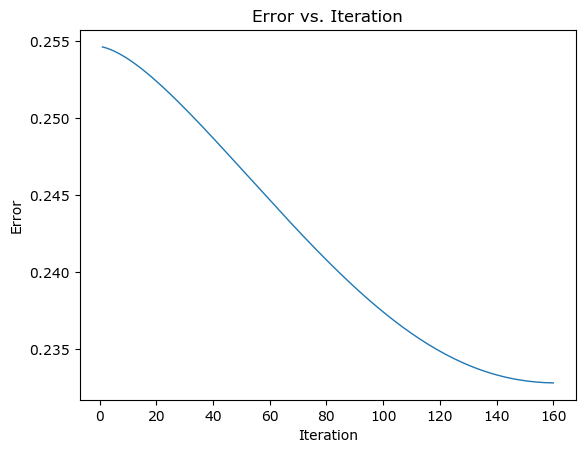

In [2]:
# 3.2 (a): plot the error over the iterations

fig1, ax1 = plt.subplots()

ax1.plot(iterations, errors, linewidth=1.0)
ax1.set_xlabel('Iteration')
ax1.set_ylabel('Error')
ax1.set_title('Error vs. Iteration')
plt.show()

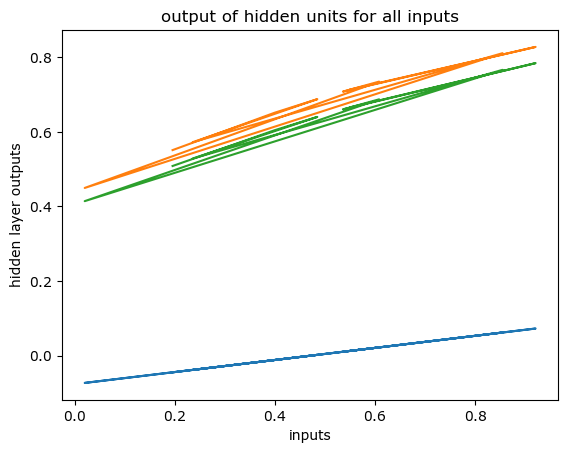

In [3]:
# 3.2 (b): plot the output of hidden units for all inputs

fig2, ax2 = plt.subplots()

for i in range(len(hidden_layer_reg[0])):
    ax2.plot(x_data, hidden_layer_reg[:, i])
ax2.set_xlabel('inputs')
ax2.set_ylabel('hidden layer outputs')
ax2.set_title('output of hidden units for all inputs')
plt.show()

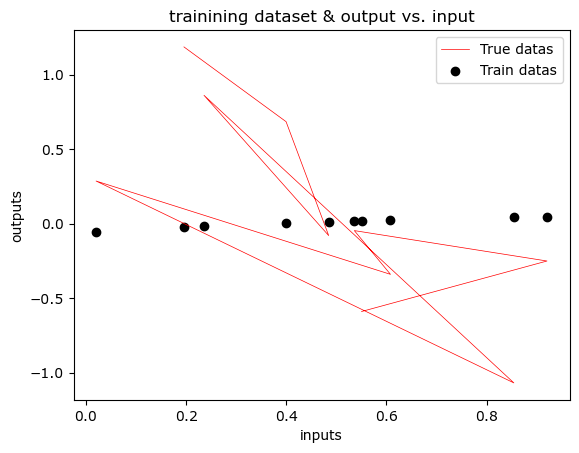

In [4]:
# 3.2 (c): plot the output values vs. input space & training dataset

fig3, ax3 = plt.subplots()

ax3.plot(x_data, y_data, color='red', linewidth=0.5, label='True datas')
ax3.scatter(x_data, output_layer_reg, color='black', label='Train datas')
ax3.set_title('trainining dataset & output vs. input')
ax3.set_xlabel('inputs')
ax3.set_ylabel('outputs')
ax3.legend(loc='upper right')
plt.show()